In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math


In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
data = pd.read_excel('VNM Historical Data Refine.xlsx')
data['Date'] = pd.to_datetime(data['Date']).dt.date
data.head()

,Date,Price,Open,High,Low,Vol,Change %
0,2018-01-02,165933.0,166750.0,168876.0,164298.0,541520,-0.25%
1,2018-01-03,160211.0,160211.0,162663.0,160211.0,879470,0.00%
2,2018-01-06,137487.0,135689.0,138305.0,135280.0,1260000,2.44%
3,2018-01-08,137604.0,138511.0,138676.0,137357.0,821720,-0.77%
4,2018-01-10,105803.0,106191.0,106346.0,105570.0,617780,-0.73%


In [4]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 1434 number of days in the dataset.


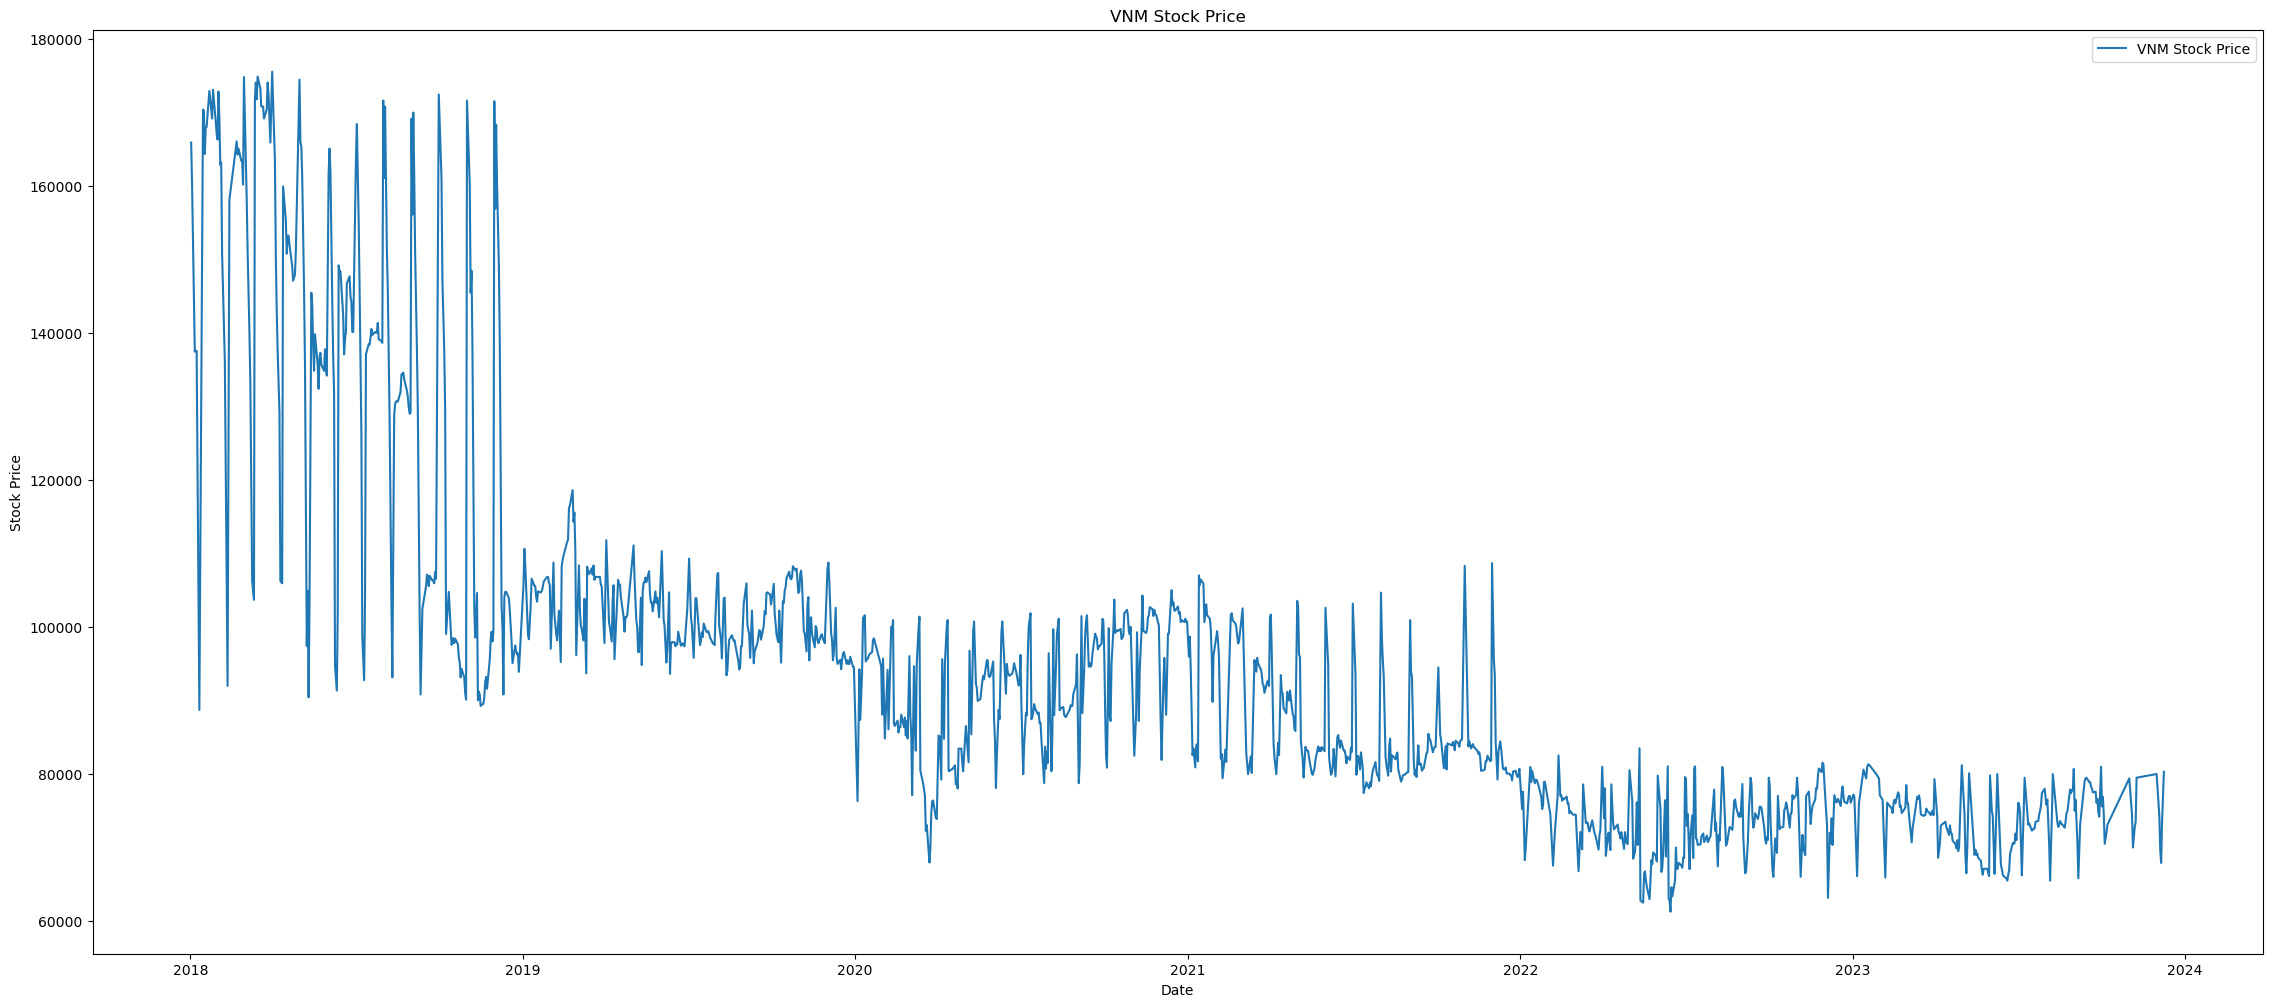

In [5]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data['Date'], data['Price'], label='VNM Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('VNM Stock Price')
plt.legend()
plt.show()

In [6]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [7]:
df = get_technical_indicators(data)

In [8]:
df = df.dropna()
df.head()

,Date,Price,Open,High,Low,Vol,Change %,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,2018-02-04,163235.0,165524.0,165851.0,162254.0,2120000,-1.63%,167217.285714,158226.857143,162387.819429,165210.061674,2822.242245,22607.040424,203440.937991,113012.776295,163887.951604,163234.0,12.002940
21,2018-02-05,150811.0,152037.0,152037.0,150811.0,743080,-0.27%,164648.285714,157506.761905,161336.986509,162937.217096,1600.230587,22590.137841,202687.037587,112326.486222,155169.983868,150810.0,11.923776
22,2018-02-07,140984.0,140160.0,140984.0,139335.0,1170000,0.59%,160909.000000,156591.190476,159519.876224,159485.781580,-34.094644,22863.039626,202317.269729,110865.111223,145712.661289,140983.0,11.856395
23,2018-02-08,136038.0,137109.0,137604.0,133317.0,1910000,-1.14%,156579.857143,156522.190476,157454.819985,155811.761323,-1643.058662,22925.679034,202373.548544,110670.832409,139262.887096,136037.0,11.820682
24,2018-02-10,106346.0,104794.0,106812.0,104794.0,697610,0.51%,147074.857143,155033.714286,153021.660860,148082.973163,-4938.687697,25124.649803,205283.013891,104784.414680,117318.295699,106345.0,11.574444


In [9]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for VNM - last {} days.'.format(last_days))
    plt.ylabel('VND')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
    

<Figure size 1600x1000 with 0 Axes>

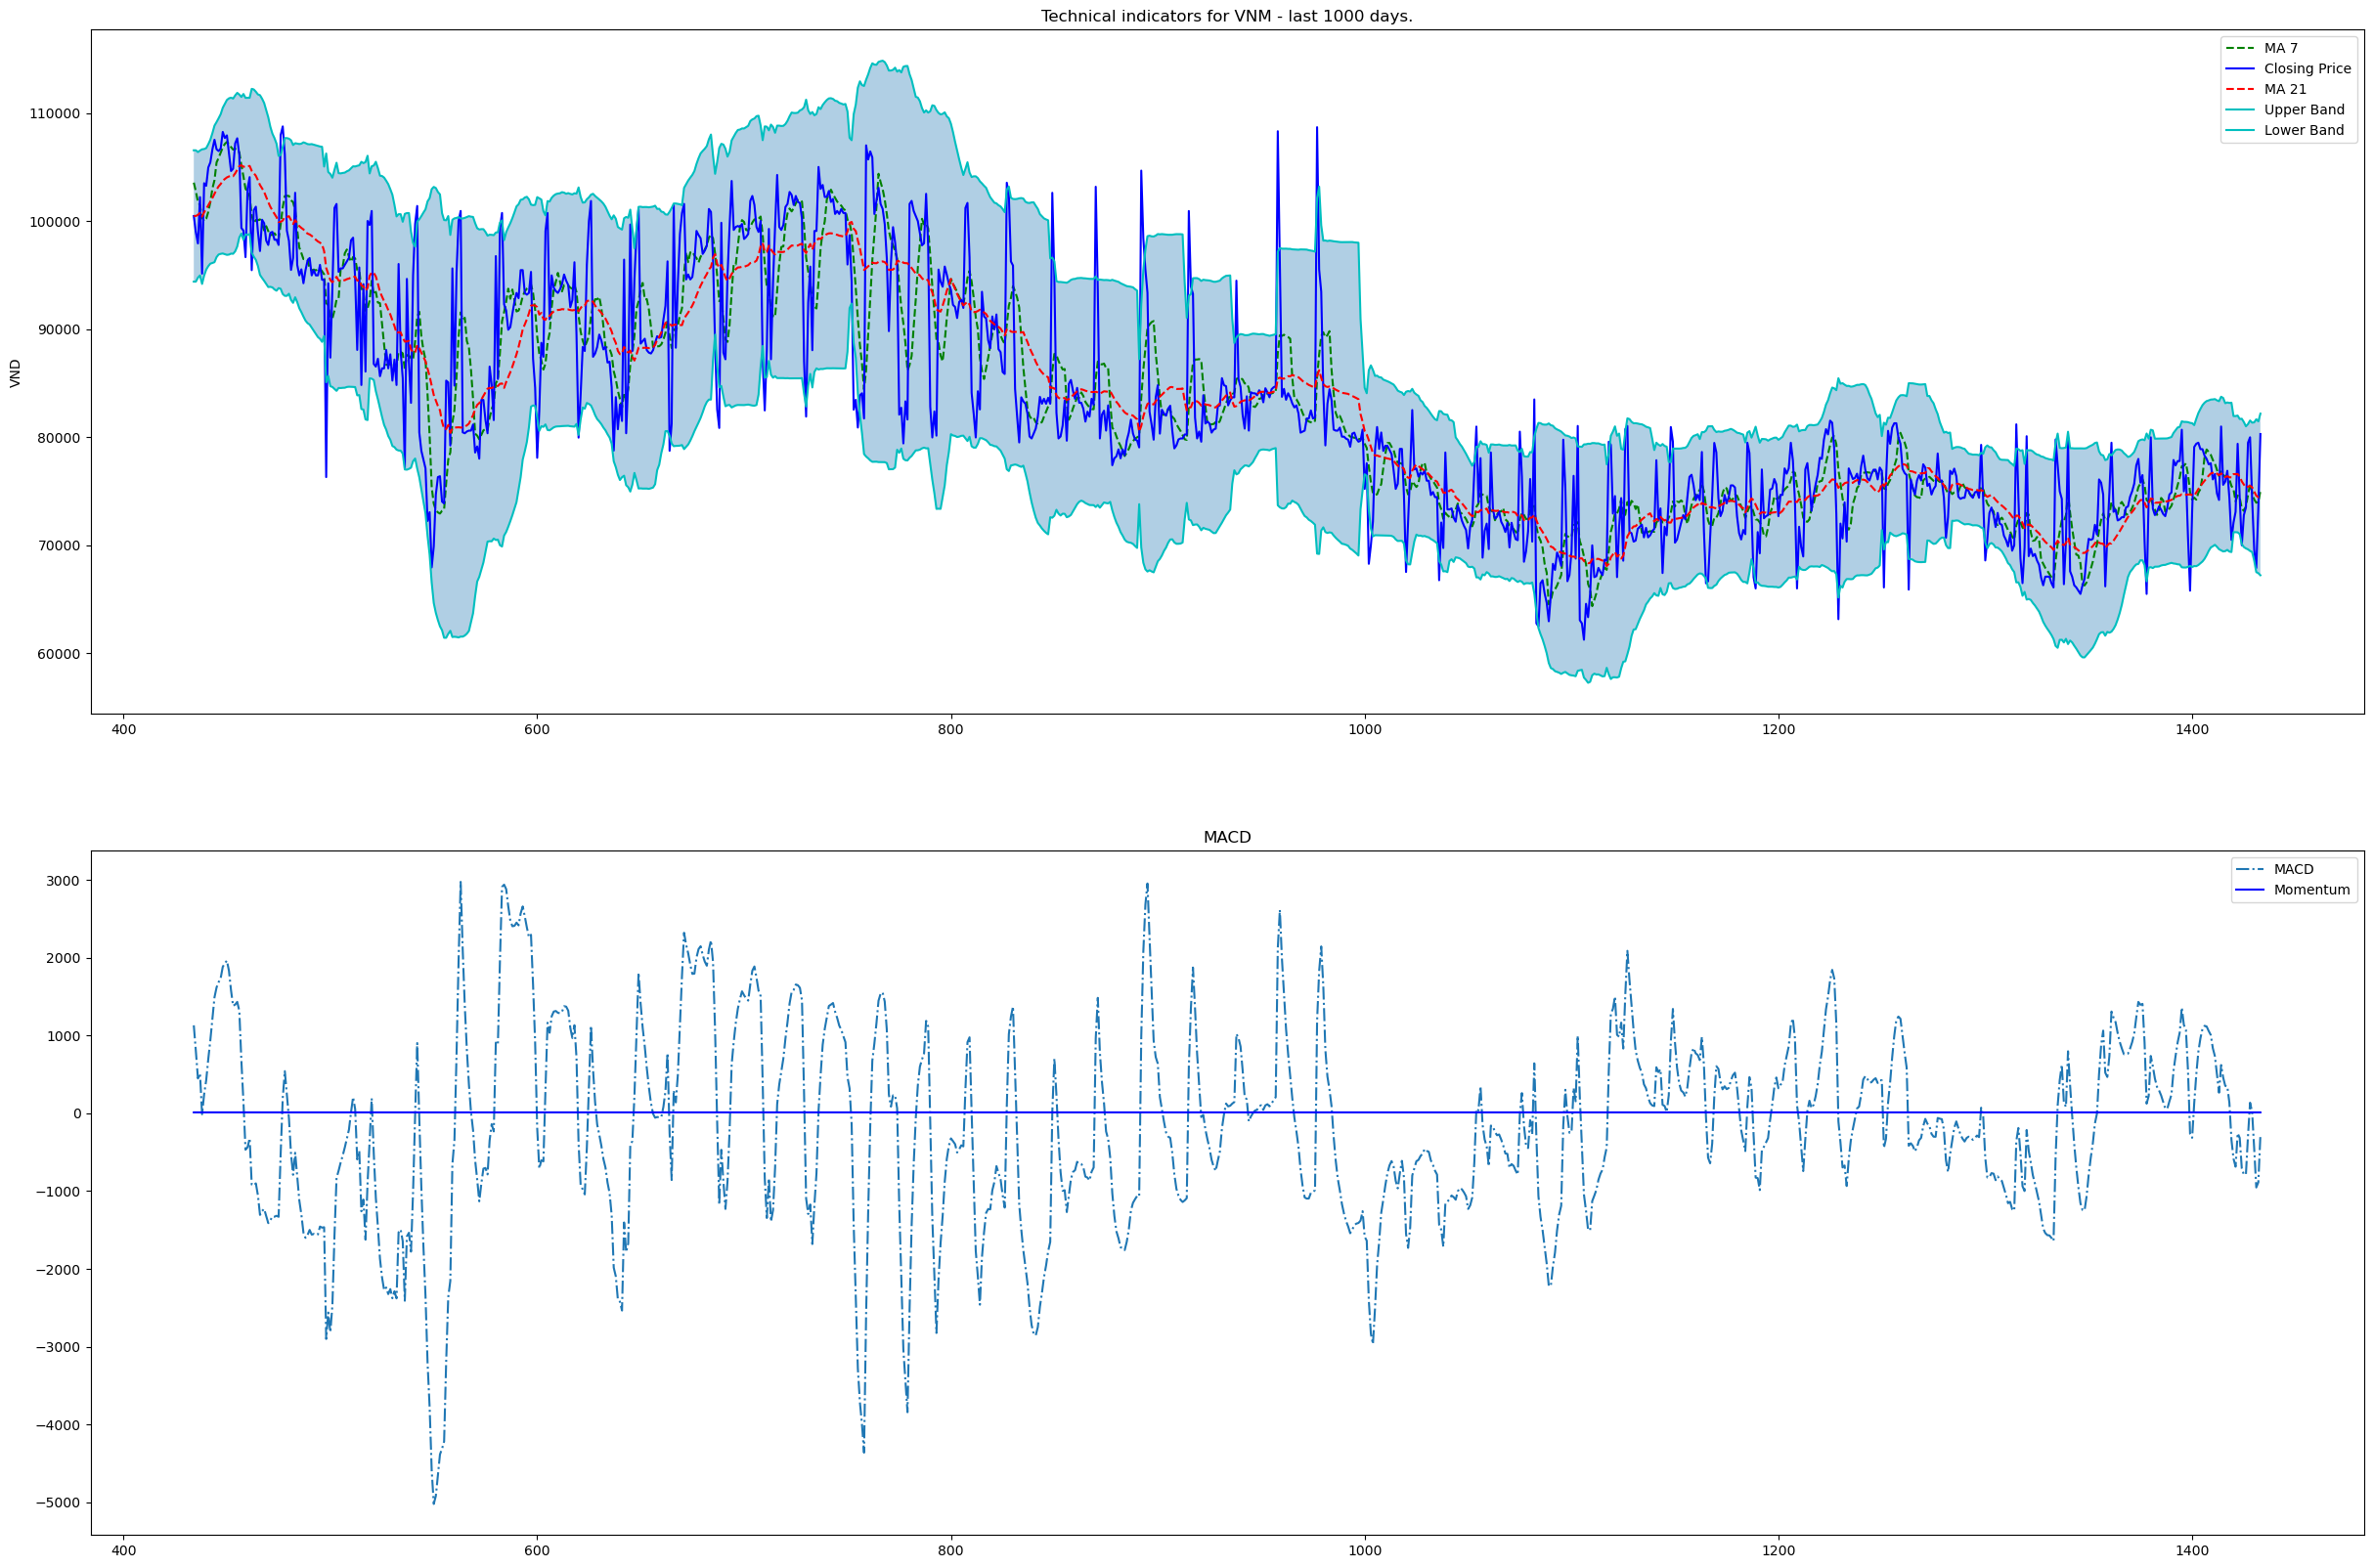

In [11]:
plot_technical_indicators(df,1000)

C:\Users\hthan\AppData\Local\Temp\ipykernel_30964\4123360880.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True).set_title('Params')


Text(0.5, 1.0, 'Params')

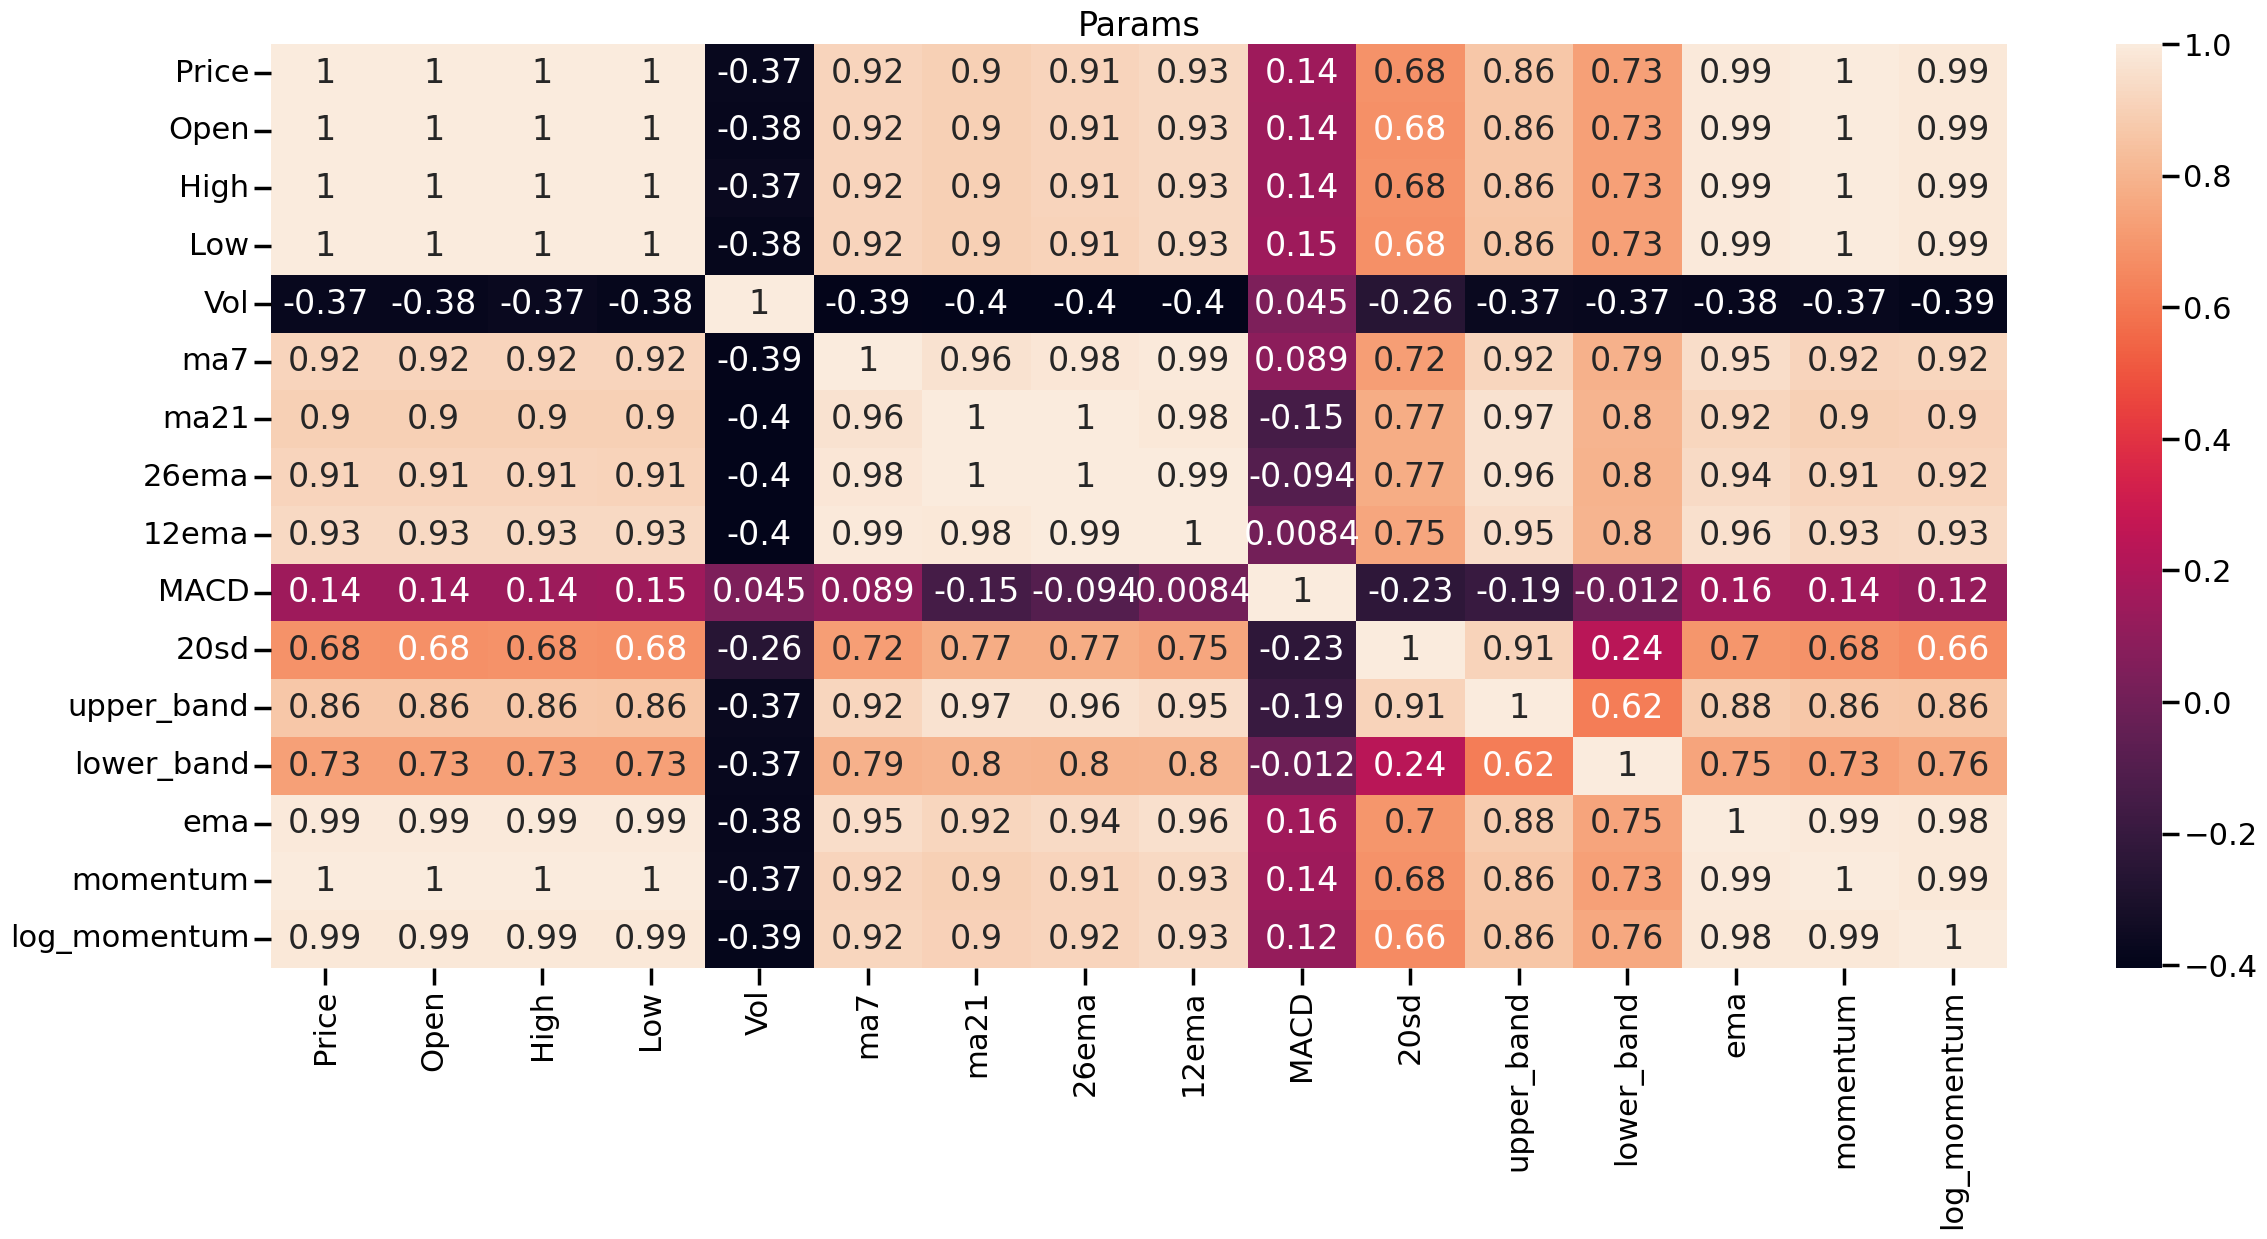

In [12]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')

In [13]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], df.shape[1]))

Total dataset has 1414 samples, and 18 features.


In [14]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change %', 'ma7',
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [15]:
import datetime
startdate = datetime.datetime.strptime('2021-10-01', "%Y-%m-%d").date()
data_training = df[df['Date'] < startdate].copy()
data_training

,Date,Price,Open,High,Low,Vol,Change %,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,2018-02-04,163235.0,165524.0,165851.0,162254.0,2120000,-1.63%,167217.285714,158226.857143,162387.819429,165210.061674,2822.242245,22607.040424,203440.937991,113012.776295,163887.951604,163234.0,12.002940
21,2018-02-05,150811.0,152037.0,152037.0,150811.0,743080,-0.27%,164648.285714,157506.761905,161336.986509,162937.217096,1600.230587,22590.137841,202687.037587,112326.486222,155169.983868,150810.0,11.923776
22,2018-02-07,140984.0,140160.0,140984.0,139335.0,1170000,0.59%,160909.000000,156591.190476,159519.876224,159485.781580,-34.094644,22863.039626,202317.269729,110865.111223,145712.661289,140983.0,11.856395
23,2018-02-08,136038.0,137109.0,137604.0,133317.0,1910000,-1.14%,156579.857143,156522.190476,157454.819985,155811.761323,-1643.058662,22925.679034,202373.548544,110670.832409,139262.887096,136037.0,11.820682
24,2018-02-10,106346.0,104794.0,106812.0,104794.0,697610,0.51%,147074.857143,155033.714286,153021.660860,148082.973163,-4938.687697,25124.649803,205283.013891,104784.414680,117318.295699,106345.0,11.574444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2021-09-24,84728.5,85008.8,85382.4,84541.7,2990000,-0.11%,83193.800000,83866.876190,83165.167751,83289.767536,124.599784,5539.992442,94946.861074,72786.891307,84729.149139,84727.5,11.347196
934,2021-09-27,82953.6,84635.1,85382.4,82953.6,5050000,-2.09%,83514.085714,83995.200000,83149.496066,83238.049453,88.553387,5483.157747,94961.515495,73028.884505,83545.449713,82952.6,11.326025
935,2021-09-28,83420.7,82953.6,83981.2,82206.3,3760000,0.56%,83887.757143,84145.766667,83169.585246,83266.149537,96.564291,5418.457651,94982.681968,73308.851366,83462.283238,83419.7,11.331640
936,2021-09-29,83700.9,83420.7,84168.0,82860.2,2760000,0.34%,84007.857143,83324.433333,83208.941895,83333.034224,124.092329,3813.659171,90951.751675,75697.114992,83621.361079,83699.9,11.334993


In [16]:
data_testing = df[df['Date'] >= startdate].copy()
data_testing

,Date,Price,Open,High,Low,Vol,Change %,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
938,2021-10-03,94499.4,93938.5,95808.0,93284.2,3390000,0.60%,85403.700000,82894.795238,84079.014107,85098.824504,1019.810396,3163.619782,89222.034803,76567.555673,90891.062342,94498.4,11.456338
939,2021-10-05,85401.2,79891.5,85401.2,79065.0,8180000,6.90%,85486.457143,83065.333333,84176.953803,85145.343811,968.390008,3199.107059,89463.547452,76667.119215,87231.154114,85400.2,11.355104
940,2021-10-06,84666.6,82095.4,85952.2,81360.7,5620000,3.48%,85477.614286,83292.719048,84213.223892,85071.690917,858.467025,3131.219945,89555.158938,77030.279157,85521.451371,84665.6,11.346465
941,2021-10-08,82095.4,80809.7,82646.3,80809.7,5970000,1.94%,85355.014286,83367.057143,84056.348048,84613.800006,557.451959,3080.579612,89528.216368,77205.897918,83237.417124,82094.4,11.315625
942,2021-10-09,80805.0,79590.6,81272.1,79403.8,3960000,1.53%,84981.342857,83424.885714,83815.507452,84027.830775,212.323323,3016.883294,89458.652303,77391.119126,81615.805708,80804.0,11.299782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,2023-12-04,74300.0,74400.0,74400.0,74000.0,979100,-0.13%,74928.571429,75366.666667,75462.564775,75477.083554,14.518779,2994.550606,81355.767879,69377.565454,75909.367652,74299.0,11.215853
1430,2023-12-05,69600.0,70400.0,70400.0,69500.0,1210000,-0.57%,74242.857143,74985.714286,75028.300718,74572.916853,-455.383865,3198.169119,81382.052524,68589.376048,71703.122551,69599.0,11.150505
1431,2023-12-06,67900.0,66000.0,68000.0,66000.0,5450000,3.19%,73942.857143,74595.238095,74500.278442,73546.314260,-953.964182,3537.863224,81670.964543,67519.511648,69167.707517,67899.0,11.125777
1432,2023-12-07,73500.0,72900.0,73500.0,72600.0,4200000,0.96%,74042.857143,74447.619048,74426.183743,73539.188989,-886.994753,3514.629290,81476.877628,67418.360467,72055.902506,73499.0,11.205027


In [17]:
training_set = df.iloc[:,1:2].values
training_set.shape
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_training_set

array([[0.89202916],
       [0.78334976],
       [0.69738772],
       ...,
       [0.05808277],
       [0.10706897],
       [0.16655222]])

In [27]:
x_train = []
y_train = []
for i in range (60,data_training.shape[0]):
    x_train.append(scaled_training_set[i-60:i])
    y_train.append(scaled_training_set[i, 0])
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(858, 60, 1)
(858,)


In [34]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(858, 60, 1)

In [35]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [29]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            12600     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_5 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_6 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [36]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [37]:
regressor.fit(x_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
14/14 [==============================] - 13s 460ms/step - loss: 0.0543
Epoch 2/50
14/14 [==============================] - 6s 389ms/step - loss: 0.0252
Epoch 3/50
14/14 [==============================] - 6s 426ms/step - loss: 0.0168
Epoch 4/50
14/14 [==============================] - 9s 630ms/step - loss: 0.0166
Epoch 5/50
14/14 [==============================] - 9s 701ms/step - loss: 0.0164
Epoch 6/50
14/14 [==============================] - 8s 567ms/step - loss: 0.0141
Epoch 7/50
14/14 [==============================] - 7s 460ms/step - loss: 0.0140
Epoch 8/50
14/14 [==============================] - 9s 657ms/step - loss: 0.0143
Epoch 9/50
14/14 [==============================] - 5s 400ms/step - loss: 0.0149
Epoch 10/50
14/14 [==============================] - 7s 492ms/step - loss: 0.0131
Epoch 11/50
14/14 [==============================] - 7s 479ms/step - loss: 0.0138
Epoch 12/50
14/14 [==============================] - 6s 405ms/step - loss: 0.0133
Epoch 13/50
14/14 [=====

In [38]:
past_60 = data_training.tail(60)

dt = past_60.append(data_testing, ignore_index = True)
dt


C:\Users\hthan\AppData\Local\Temp\ipykernel_30964\2222889864.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = past_60.append(data_testing, ignore_index = True)


,Date,Price,Open,High,Low,Vol,Change %,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,2021-07-13,77412.1,79065.0,79432.3,77320.2,2880000,-2.32%,80891.214286,83909.409524,83705.722722,82679.065898,-1026.656824,5332.786947,94574.983418,73243.835629,78720.235400,77411.1,11.256885
1,2021-07-14,78054.9,78054.9,78697.7,77412.1,4180000,0.83%,80628.842857,83563.957143,83287.143261,81967.655760,-1319.487501,5470.747466,94505.452074,72622.462212,78276.678467,78053.9,11.265155
2,2021-07-15,78238.5,78054.9,79248.7,77595.7,3280000,0.24%,80077.857143,83275.347619,82913.169686,81393.939489,-1519.230197,5588.613946,94452.575511,72098.119728,78251.226156,78237.5,11.267504
3,2021-07-16,78881.3,78514.0,79156.8,78330.4,1450000,0.82%,79566.228571,83052.333333,82614.512673,81007.379568,-1607.133105,5669.354731,94391.042796,71713.623870,78671.275385,78880.3,11.275687
4,2021-07-19,78054.9,77503.9,78054.9,77136.6,4110000,-1.05%,79200.042857,82741.866667,82276.763586,80553.151942,-1723.611644,5759.619000,94261.104667,71222.628667,78260.358462,78053.9,11.265155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,2023-12-04,74300.0,74400.0,74400.0,74000.0,979100,-0.13%,74928.571429,75366.666667,75462.564775,75477.083554,14.518779,2994.550606,81355.767879,69377.565454,75909.367652,74299.0,11.215853
552,2023-12-05,69600.0,70400.0,70400.0,69500.0,1210000,-0.57%,74242.857143,74985.714286,75028.300718,74572.916853,-455.383865,3198.169119,81382.052524,68589.376048,71703.122551,69599.0,11.150505
553,2023-12-06,67900.0,66000.0,68000.0,66000.0,5450000,3.19%,73942.857143,74595.238095,74500.278442,73546.314260,-953.964182,3537.863224,81670.964543,67519.511648,69167.707517,67899.0,11.125777
554,2023-12-07,73500.0,72900.0,73500.0,72600.0,4200000,0.96%,74042.857143,74447.619048,74426.183743,73539.188989,-886.994753,3514.629290,81476.877628,67418.360467,72055.902506,73499.0,11.205027


In [48]:
dt = dt.drop(columns = ["Date","Change %"])
dt

,Price,Open,High,Low,Vol,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,77412.1,79065.0,79432.3,77320.2,2880000,80891.214286,83909.409524,83705.722722,82679.065898,-1026.656824,5332.786947,94574.983418,73243.835629,78720.235400,77411.1,11.256885
1,78054.9,78054.9,78697.7,77412.1,4180000,80628.842857,83563.957143,83287.143261,81967.655760,-1319.487501,5470.747466,94505.452074,72622.462212,78276.678467,78053.9,11.265155
2,78238.5,78054.9,79248.7,77595.7,3280000,80077.857143,83275.347619,82913.169686,81393.939489,-1519.230197,5588.613946,94452.575511,72098.119728,78251.226156,78237.5,11.267504
3,78881.3,78514.0,79156.8,78330.4,1450000,79566.228571,83052.333333,82614.512673,81007.379568,-1607.133105,5669.354731,94391.042796,71713.623870,78671.275385,78880.3,11.275687
4,78054.9,77503.9,78054.9,77136.6,4110000,79200.042857,82741.866667,82276.763586,80553.151942,-1723.611644,5759.619000,94261.104667,71222.628667,78260.358462,78053.9,11.265155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,74300.0,74400.0,74400.0,74000.0,979100,74928.571429,75366.666667,75462.564775,75477.083554,14.518779,2994.550606,81355.767879,69377.565454,75909.367652,74299.0,11.215853
552,69600.0,70400.0,70400.0,69500.0,1210000,74242.857143,74985.714286,75028.300718,74572.916853,-455.383865,3198.169119,81382.052524,68589.376048,71703.122551,69599.0,11.150505
553,67900.0,66000.0,68000.0,66000.0,5450000,73942.857143,74595.238095,74500.278442,73546.314260,-953.964182,3537.863224,81670.964543,67519.511648,69167.707517,67899.0,11.125777
554,73500.0,72900.0,73500.0,72600.0,4200000,74042.857143,74447.619048,74426.183743,73539.188989,-886.994753,3514.629290,81476.877628,67418.360467,72055.902506,73499.0,11.205027


In [49]:
inputs = scaler.fit_transform(dt)
print(inputs.shape)
inputs

(556, 16)


array([[0.34042266, 0.36620559, 0.35436061, ..., 0.430011  , 0.34042266,
        0.40802731],
       [0.35397044, 0.34474333, 0.33836368, ..., 0.41837098, 0.35397044,
        0.42244568],
       [0.35784003, 0.34474333, 0.35036247, ..., 0.41770304, 0.35784003,
        0.42654213],
       ...,
       [0.13994381, 0.08860488, 0.10540642, ..., 0.17932925, 0.13994381,
        0.17942928],
       [0.25797049, 0.23521375, 0.22517655, ..., 0.25512257, 0.25797049,
        0.31760838],
       [0.4012886 , 0.36482449, 0.38196654, ..., 0.39935278, 0.4012886 ,
        0.47188917]])

In [53]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((496, 60), (496,))

In [54]:
y_pred = regressor.predict(X_test)

16/16 [==============================] - 2s 75ms/step


In [55]:
y_pred

array([[0.4820832 ],
       [0.4819981 ],
       [0.4818145 ],
       [0.48154986],
       [0.48130232],
       [0.48108688],
       [0.48101684],
       [0.48107257],
       [0.48132524],
       [0.4817137 ],
       [0.48223573],
       [0.4828307 ],
       [0.48349607],
       [0.48421687],
       [0.48497742],
       [0.48602158],
       [0.48709768],
       [0.48815942],
       [0.48916566],
       [0.48991057],
       [0.49054098],
       [0.49090666],
       [0.49106976],
       [0.49105072],
       [0.49087447],
       [0.49084276],
       [0.49104044],
       [0.49157724],
       [0.49253553],
       [0.49396688],
       [0.4957223 ],
       [0.49770218],
       [0.49984545],
       [0.5020225 ],
       [0.5040712 ],
       [0.5058978 ],
       [0.50739187],
       [0.5085136 ],
       [0.5096053 ],
       [0.5102434 ],
       [0.5102046 ],
       [0.5089425 ],
       [0.5068437 ],
       [0.5042448 ],
       [0.50142044],
       [0.49890065],
       [0.49667537],
       [0.495

In [57]:
scale = 1/scaler.scale_[0]

In [58]:
y_pred = y_pred*scale
y_test = y_test*scale

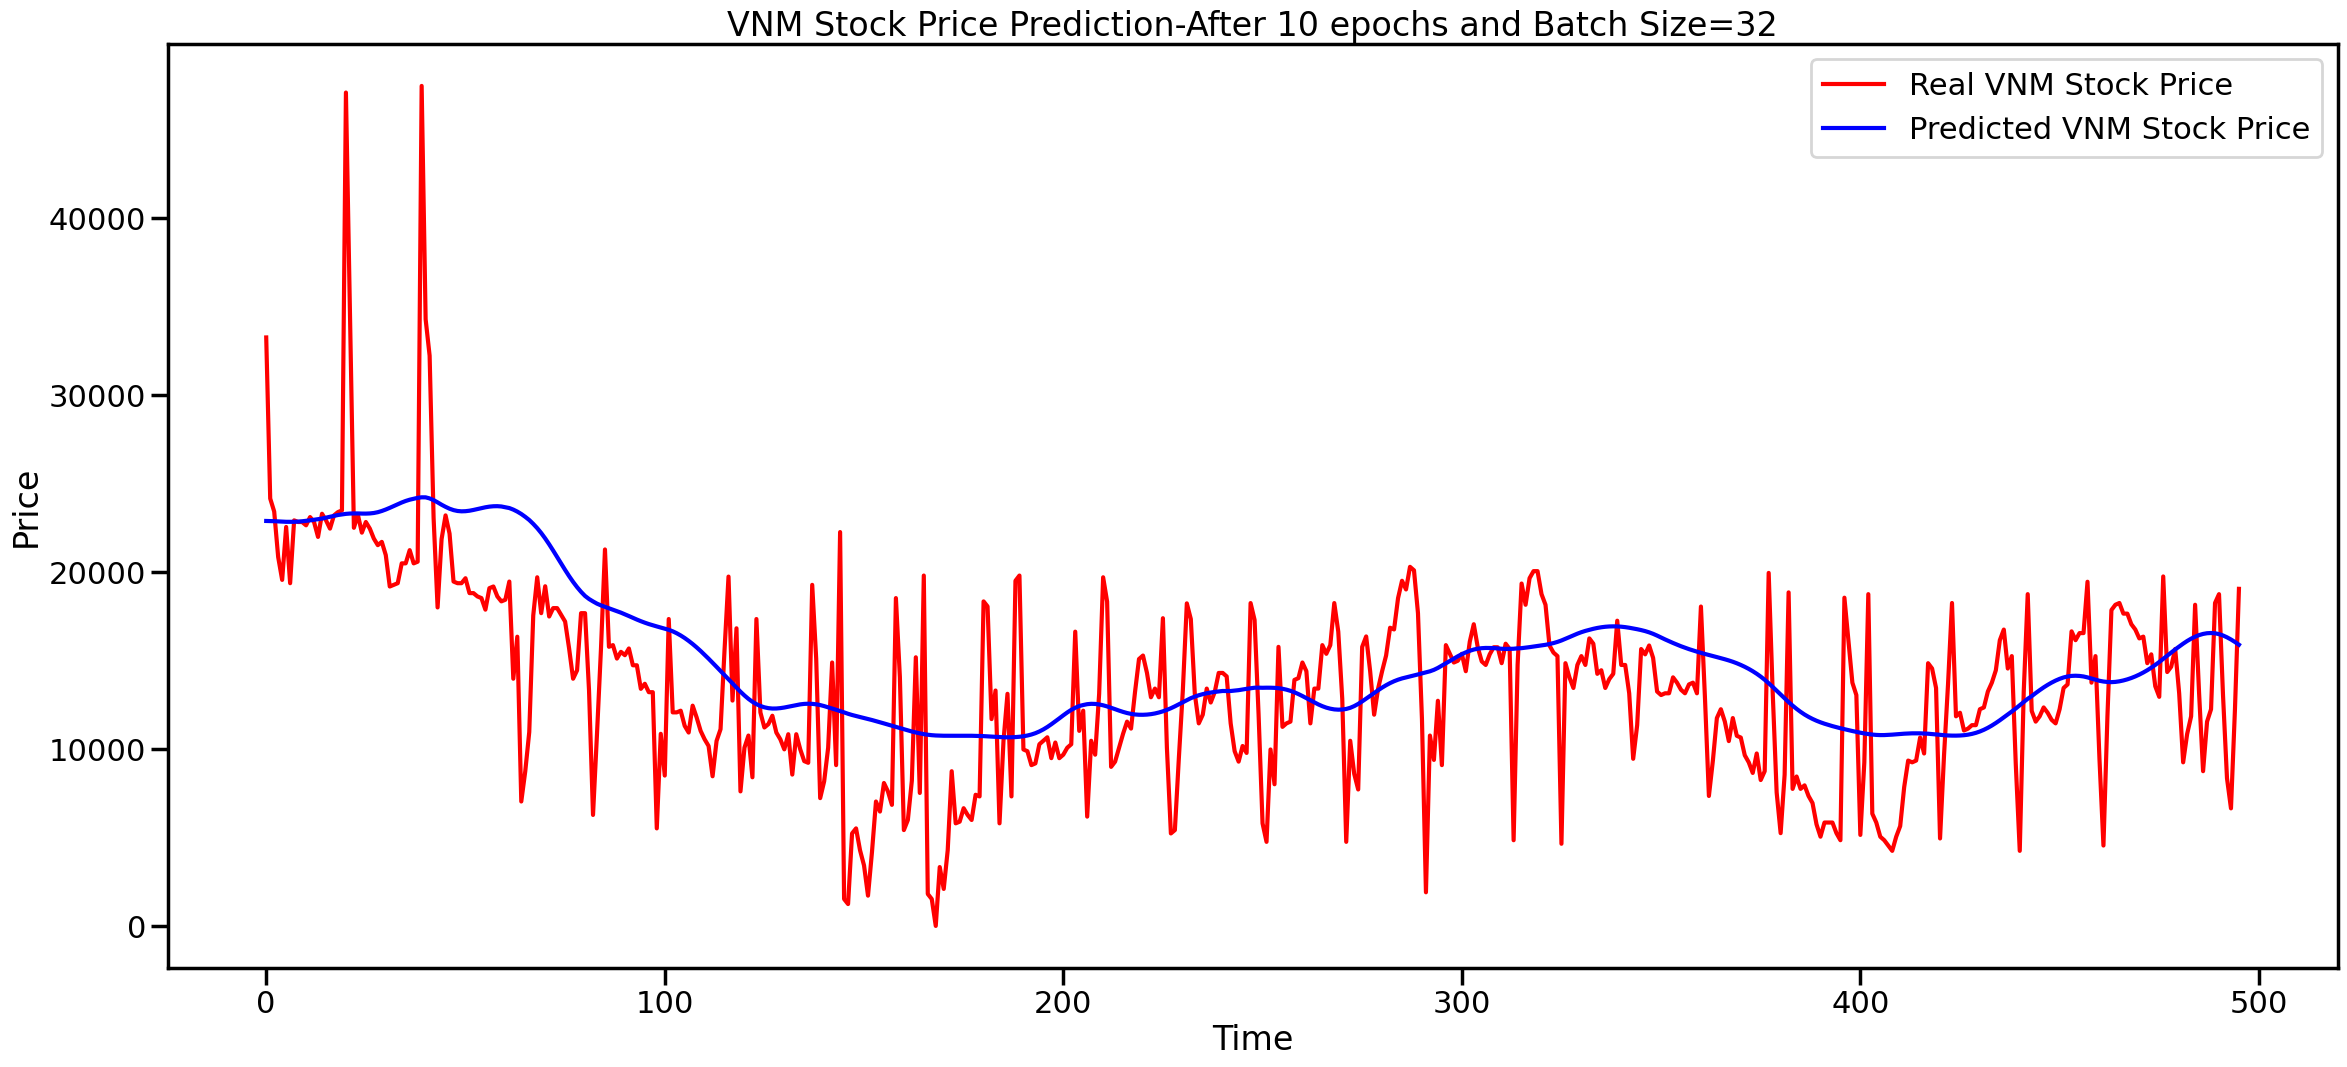

In [60]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real VNM Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted VNM Stock Price')
plt.title('VNM Stock Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()